In [1]:
import sys
sys.path.append('../../SABR')

sys.path.append('../../heston')
sys.path.append('../../heston/heston calibration/')

In [2]:
from SABR_montecarlo import *

from montecarlo import *
from heston import *
from sabr_approx import *
from heston_derivatives import *
from heston_calibration import *

from implied_volatility import *

from matplotlib import pyplot as plt
import numpy as np

In [3]:
r = 0.1
d = 0.55
k = 2.5
sig = 0.9
theta = 0.15
rho = -0.8


S0 = 1.0
K = 1.0
T = 1.5

Kn = K * np.exp( np.linspace(-np.log(10), np.log(5), 100) )
Sn = S0 * np.exp( np.linspace(-np.log(10), np.log(2), 120) )

#Kn = Kn.reshape(-1, 1)
#Sn = Sn.reshape()


Nt = 100
Nu = 50
tn = np.linspace(0, T, Nt)

v0 = 0.175
x0 = np.log(S0)

In [4]:
heston_params = np.asarray( [v0, theta, rho, k, sig] )

kwargs = dict(zip( ["v0", "theta","rho","k","sig"], heston_params ))

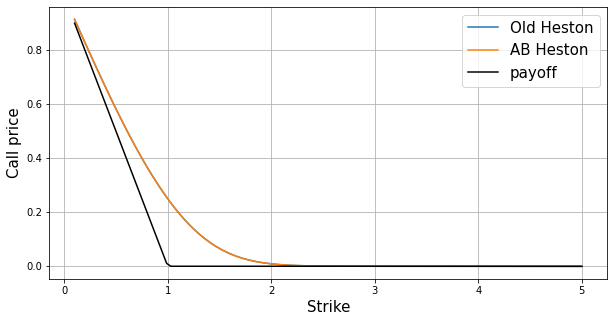

In [5]:
C1 = getOptionPrice(S0, Kn, T, Nu, r, **kwargs)
C2 = getOptionPriceAB(S0, Kn, T, Nu, r, **kwargs)
payoff = np.maximum(S0 - Kn, 0.0)


plt.figure(figsize=(10, 5))
plt.plot(Kn, C1, label='Old Heston')
plt.plot(Kn, C2, label='AB Heston')
plt.plot(Kn, np.maximum(S0 - Kn, 0.0), c='k', label='payoff')

plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=15)
plt.ylabel("Call price", fontsize=15)
None

In [6]:
error_call = np.linalg.norm(C1 - C2) / np.linalg.norm(C1) * 100
print(f"error_call = {error_call}")

error_call = 2.889432270241398e-14


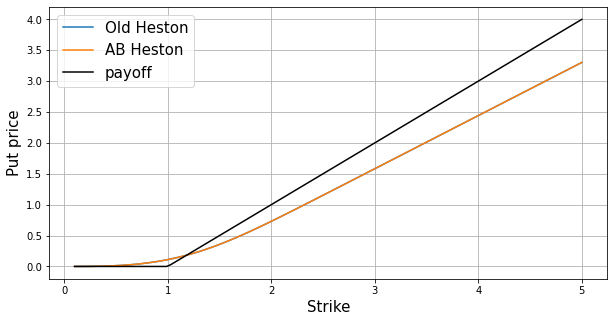

In [7]:
P1 = getOptionPrice(S0, Kn, T, Nu, r, k, sig, theta, rho, v0, isCall=False)
P2 = getOptionPriceAB(S0, Kn, T, Nu, r, v0, theta, rho, k, sig, isCall=False)
payoff = np.maximum(Kn - S0, 0.0)


plt.figure(figsize=(10, 5))
plt.plot(Kn, P1, label='Old Heston')
plt.plot(Kn, P2, label='AB Heston')
plt.plot(Kn, payoff, c='k', label='payoff')

plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=15)
plt.ylabel("Put price", fontsize=15)
None

In [8]:
error_put = np.linalg.norm(P1 - P2) / np.linalg.norm(P1) * 100
print(f"error_put = {error_put}")

error_put = 2.1921078973964817e-14


# Moment Matching Test

In [9]:
n_iter = 10

Npaths = 2 ** (np.arange(5, 12))

errors = []
errors_ = []

for Npath in Npaths:
    err = []
    err_ = []
    for i in range(n_iter):
        v, x = generate_path_chi(r, k, sig, theta, rho, x0, v0, tn, Npath)
        S = np.exp(x)
        S_ = S - np.mean(S) + S0 * np.exp(r * T)
        
        C = np.exp(-r * T) * np.mean( np.maximum(S.reshape(1, -1) - Kn.reshape(-1, 1), 0.0), axis=1 )
        C_ = np.exp(-r * T) * np.mean( np.maximum(S_.reshape(1, -1) - Kn.reshape(-1, 1), 0.0), axis=1 )
        
        error = np.linalg.norm(C1 - C) ** 2
        error_ = np.linalg.norm(C1 - C_) ** 2
        
        err.append(error)
        err_.append(error_)
    errors.append(np.mean(err))
    errors_.append(np.mean(err_))

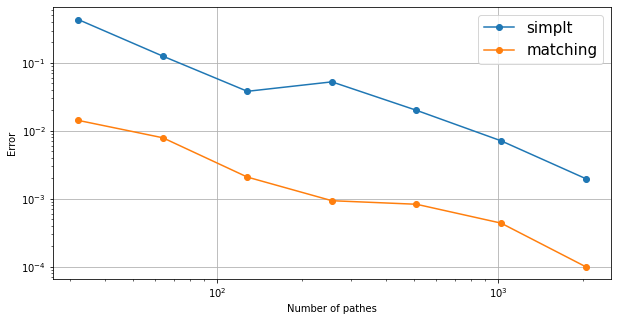

In [10]:
plt.figure(figsize=(10, 5))
plt.loglog(Npaths, errors, '-o', label='simplt')
plt.loglog(Npaths, errors_, '-o', label='matching')
plt.legend(fontsize=15)
plt.xlabel("Number of pathes", fontsize=10)
plt.ylabel("Error", fontsize=10)
plt.grid()

# Derivatives check

In [11]:
u = 10

phi, ders = getPhiDerFinite(u, T, **kwargs)
phi_, ders_ = getPhiDerAB(u, T, **kwargs)

ders = np.asarray(ders)
ders_ = np.asarray(ders_)

err = np.linalg.norm(ders-ders_)

print(err)

9.580151945820307e-06


In [12]:
u = 10 - 1j

phi, ders = getPhiDerFinite(u, T, **kwargs)
phi_, ders_ = getPhiDerAB(u, T, **kwargs)

ders = np.asarray(ders)
ders_ = np.asarray(ders_)

err = np.linalg.norm(ders-ders_)

print(err)

9.726732168845398e-06


In [15]:
C, ders = getOptionPriceDerFinite(S0, K, T, Nu, r, *heston_params)

In [17]:
C_, ders_ = getOptionPriceDerAB(S0, K, T, Nu, r, *heston_params)

In [18]:
C, C_

(array([0.24994113]), array([0.24994113]))

In [19]:
np.linalg.norm(ders - ders_)

1.015096456478547e-06

# Volatility Surface

In [20]:
K0 = S0

In [21]:
Nk = 100
Kn = K0 + np.linspace(-0.8, 0.8, Nk)

#Kn = Kn.reshape(-1, 1)
#Sn = Sn.reshape()


Nt = 5
Tn = T * np.linspace(0.5, T * 2.0, Nt)

In [22]:
C, IV = getVolatilitySurface(S0, Kn, Tn, Nu, r, *heston_params)

In [23]:
X, Y = np.meshgrid(Tn, Kn)

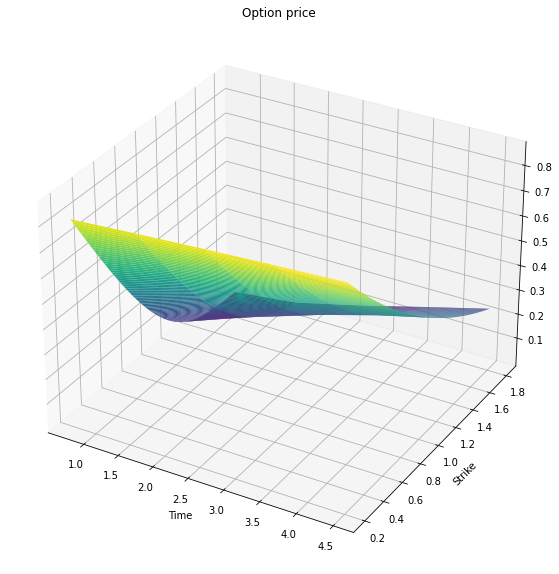

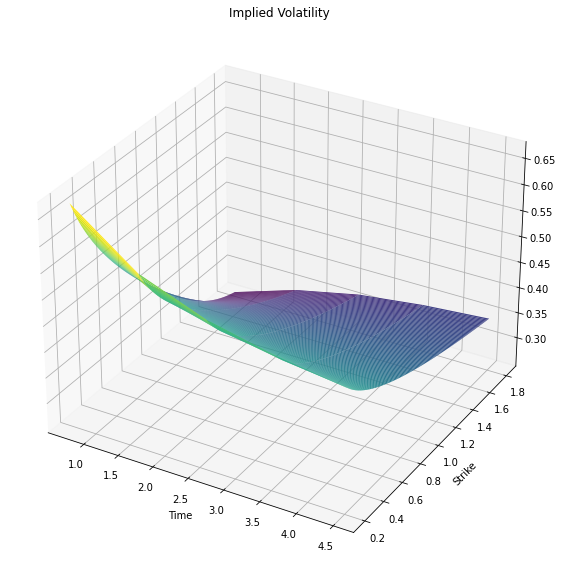

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, C, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Option price')
plt.xlabel("Time")
plt.ylabel("Strike")
None

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, IV, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Implied Volatility')
plt.xlabel("Time")
plt.ylabel("Strike")
None

# Optimization

In [25]:
def gen_random_heston_params():
    v0 = np.random.rand(1) * 0.15 + 0.01
    theta = np.random.rand(1) * 0.15 + 0.01
    
    rho = -0.9 + (1.8) * np.random.rand(1)
    k = np.random.rand(1) * 2 + 1.0
    sig = np.random.rand(1) * 0.02 + 0.01
    
    return v0[0], theta[0], rho[0], k[0], sig[0]

In [26]:
v0_0    = 0.175
theta_0 = 0.02
rho_0   = 0.5
k_0     = 2.0
sig_0   = 0.5

In [27]:
w = 1 / (0.1 + np.abs(Kn - S0) ** 2)

In [28]:
weights = [w[:] for _ in range(len(Tn))]

In [29]:
heston_params_0 = np.asarray( [v0_0, theta_0, rho_0, k_0, sig_0] )

In [31]:
C0, IV0 = getVolatilitySurface(S0, Kn, Tn, Nu, r, *heston_params_0)

In [32]:
Niter = 500

In [33]:
f = lambda _z: getResudalAndGrad(C0, S0, Kn, Tn, Nu, r, weights, *_z)
proj = my_clip 

In [34]:
for _ in range(20):
    heston_params = np.asarray(gen_random_heston_params())
    heston_params, fs = MyAlgorithm(Niter, f, proj, heston_params)
    print(fs[-1])

1.2609510919293816e-09
2.418151450669724e-09
6.182625317587846e-09
9.98124633819967e-10
6.23119029979977e-10
7.927419944874039e-10
4.839877752605154e-09
7.795748059473272e-09
5.951311477945293e-09
1.0472709549407714e-09
3.927321898454441e-10
3.7204104502943503e-09
9.667581707899302e-10
6.254706879902346e-09
7.562629844925376e-09
5.185122634043683e-10
8.21762659096292e-10
1.0113527781908621e-09
2.4847690751897077e-09
5.11897627847677e-10


# Calibration to SABR

In [35]:
alpha_sabr = 0.15
beta_sabr = 0.25
rho_sabr = -0.25

sig0_sabr = 0.3

In [36]:
Csabr = np.zeros((Nk, Nt))
IVsabr = np.zeros_like(Csabr)

tn = np.linspace(0, 1, 100)
Npaths = 100000

for t in range(Nt):
    
    F0 = S0 * np.exp(r * Tn[t])
    
    F = SabrEulerModified(F0, sig0_sabr, Npaths, tn * Tn[t], alpha_sabr, beta_sabr, rho_sabr)
    F = F - np.mean(F) + F0
    payoff = np.exp(-r * Tn[t]) * np.maximum(F.reshape(-1, 1) - Kn.reshape(1, -1), 0.0)
    C = np.mean(payoff, axis=0)
    Csabr[:, t] = C.reshape(-1) 
    
    IVsabr[:, t] = getIV(C.reshape(-1), Kn.reshape(-1), S0, r, Tn[t])

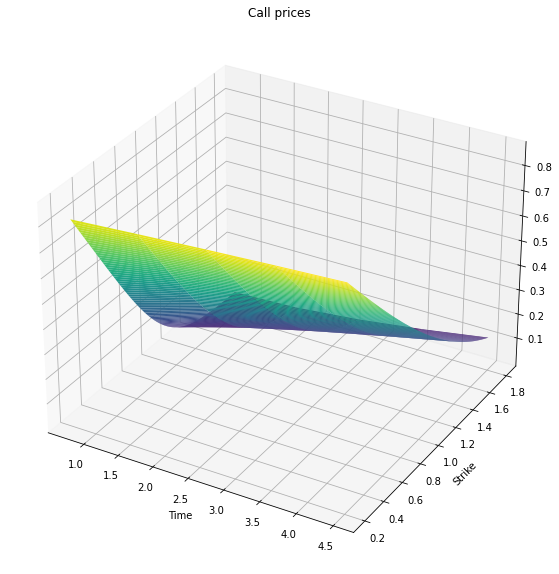

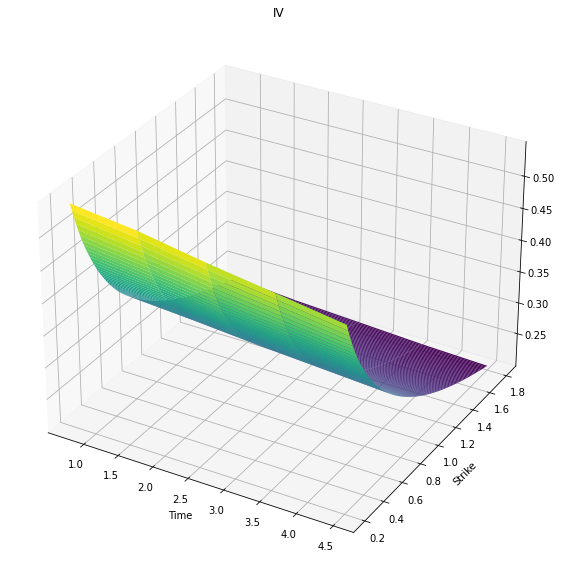

In [37]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Csabr, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Call prices')
plt.xlabel("Time")
plt.ylabel("Strike")
None

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, IVsabr, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('IV')
plt.xlabel("Time")
plt.ylabel("Strike")
None

In [38]:
w = np.ones_like(Kn)
w = 1 / (0.2 + np.abs(Kn - S0) ** 2 )
weights = [w[:] for _ in range(len(Tn))] 

In [39]:
Niter = 200

In [40]:
f = lambda _z: getResudalAndGrad(Csabr, S0, Kn, Tn, Nu, r, weights, *_z)
proj = my_clip

In [41]:
heston_params = np.asarray(gen_random_heston_params())
heston_params, fs = MyAlgorithm(Niter, f, proj, heston_params)

In [42]:
heston_params

array([ 0.09374115,  0.01908238, -0.52354724,  0.21185267,  0.26872772])

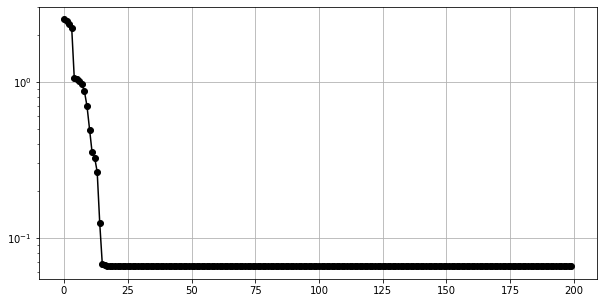

In [43]:
plt.figure(figsize=(10, 5))
plt.semilogy(fs, '-ok')
plt.grid()

In [44]:
C_calibrated, IV_calibrated = getVolatilitySurface(S0, Kn, Tn, Nu, r, *heston_params)

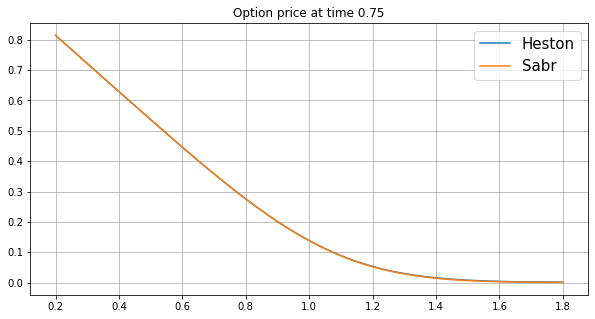

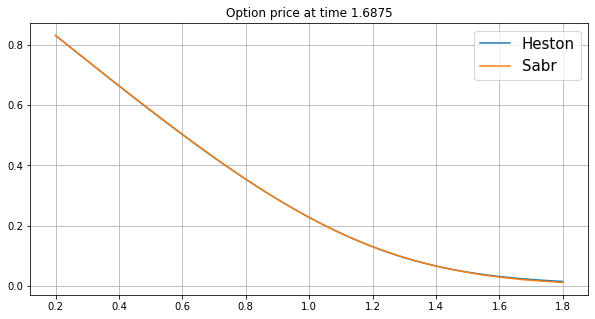

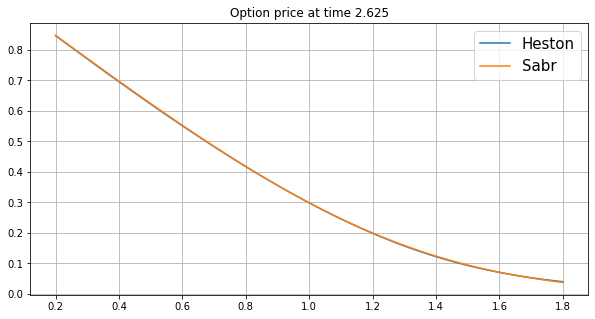

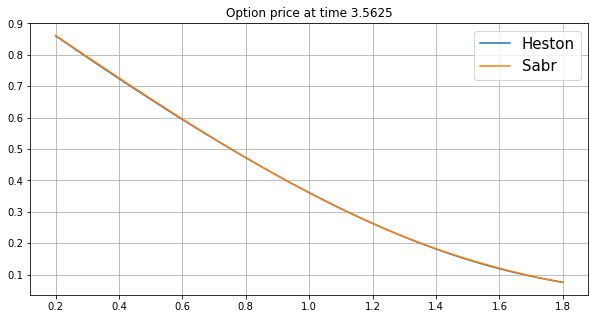

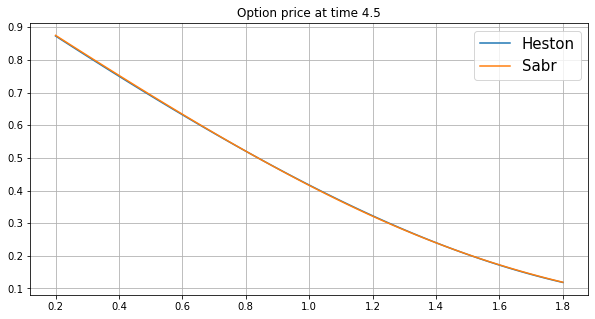

In [45]:
for t in range(Nt):
    plt.figure(figsize=(10, 5))
    plt.plot(Kn, C_calibrated[:, t], label='Heston')
    plt.plot(Kn, Csabr[:, t], label='Sabr')
    plt.title(f'Option price at time {Tn[t]}')
    plt.legend(fontsize=15)
    plt.grid()

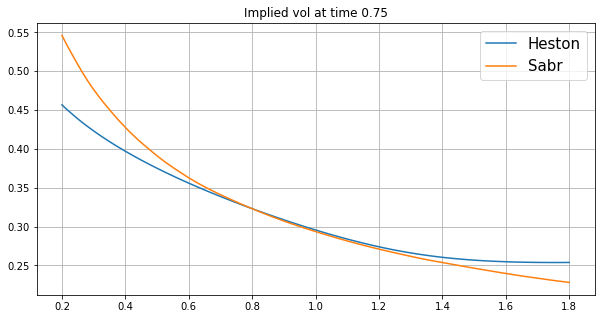

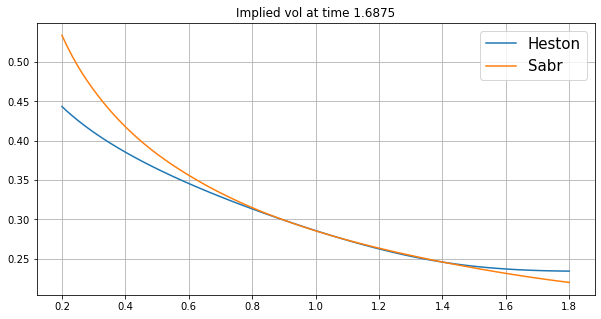

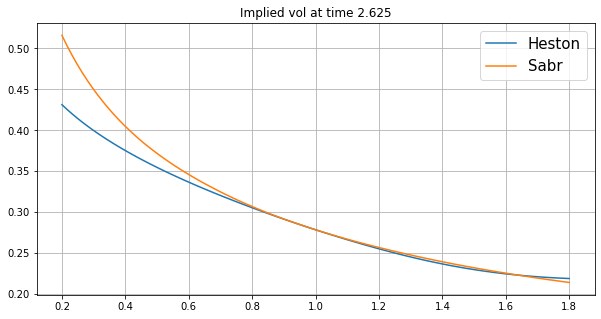

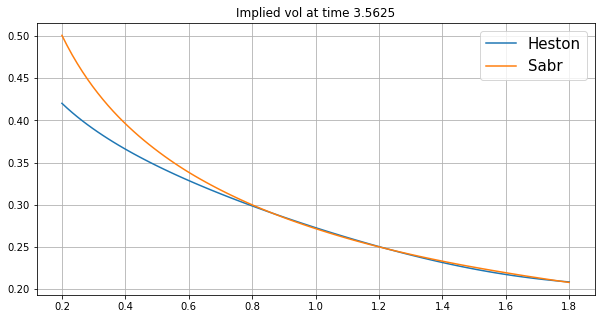

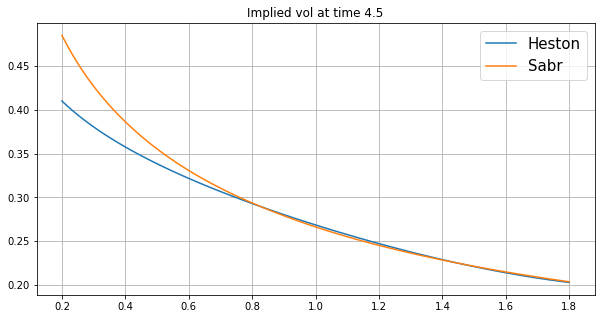

In [46]:
for t in range(Nt):
    plt.figure(figsize=(10, 5))
    plt.plot(Kn, IV_calibrated[:, t], label='Heston')
    plt.plot(Kn, IVsabr[:, t], label='Sabr')
    plt.title(f'Implied vol at time {Tn[t]}')
    plt.legend(fontsize=15)
    plt.grid()